<a href="https://colab.research.google.com/github/AkotoChristine/Chat_bot/blob/main/Phi_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==2.8.0+cu126 torchvision==0.23.0+cu126 torchaudio==2.8.0+cu126 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.44.2 accelerate==0.33.0 peft bitsandbytes --quiet


Looking in indexes: https://download.pytorch.org/whl/cu126
  Using cached https://download.pytorch.org/whl/cu126/nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.5 kB)
Using cached https://download.pytorch.org/whl/cu126/nvidia_cublas_cu12-12.6.4.1-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (393.1 MB)


In [2]:
import re
import pandas as pd
import os
import gc
import wandb
from datasets import Dataset, DatasetDict
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
file_path = '/content/drive/MyDrive/preprocessed_recipes.csv'
main_data = pd.read_csv(file_path)

In [5]:
main_data.head(5)

,instruction,response
0,Can you give me a recipe for Vegetarian Bobotie?,**Recipe:** Vegetarian Bobotie\n\n**Ingredient...
1,Can you give me a recipe for Citrus Couscous S...,**Recipe:** Citrus Couscous Salad\n\n**Ingredi...
2,Can you give me a recipe for Tofu Kebabs?,**Recipe:** Tofu Kebabs\n\n**Ingredients:**\n-...
3,Can you give me a recipe for Coffee Milk Syrup?,**Recipe:** Coffee Milk Syrup\n\n**Ingredients...
4,Can you give me a recipe for Lemony Apple Chic...,**Recipe:** Lemony Apple Chicken Couscous\n\n*...


## tokenization and normlisation

In [6]:
def normalize_text(text):
    text = str(text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)               # collapse multiple spaces
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # remove URLs
    text = re.sub(r'[“”‘’]', '"', text)            # normalize quotes
    text = re.sub(r'[\x00-\x1F\x7F]', '', text)    # remove control chars
    text = re.sub(r'\s([?.!"](?:\s|$))', r'\1', text) # fix spacing before punct
    return text.strip()


# apply normalization
import re

main_data['instruction'] = main_data['instruction'].apply(normalize_text)
main_data['response'] = main_data['response'].apply(normalize_text)


main_data[['instruction','response']].head(4)

,instruction,response
0,Can you give me a recipe for Vegetarian Bobotie?,**Recipe:** Vegetarian Bobotie **Ingredients:*...
1,Can you give me a recipe for Citrus Couscous S...,**Recipe:** Citrus Couscous Salad **Ingredient...
2,Can you give me a recipe for Tofu Kebabs?,**Recipe:** Tofu Kebabs **Ingredients:** - 10 ...
3,Can you give me a recipe for Coffee Milk Syrup?,**Recipe:** Coffee Milk Syrup **Ingredients:**...


## tokenisation

In [8]:
from transformers import AutoTokenizer
from datasets import Dataset

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct", trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Convert pandas to Dataset FIRST (keep instruction and response)
dataset = Dataset.from_pandas(main_data[['instruction', 'response']])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [16]:
def tokenize_function(examples):
    prompts = []
    for instruction, response in zip(examples["instruction"], examples["response"]):
        messages = [
            {"role": "user", "content": instruction},
            {"role": "assistant", "content": response}
        ]
        formatted = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=False
        )
        prompts.append(formatted)

    # NO PADDING HERE - let the data collator handle it
    tokenized = tokenizer(
        prompts,
        truncation=True,
        max_length=512,  # Increased for longer responses
        padding=False,  # Changed from "max_length"
        return_tensors=None
    )

    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

In [18]:
tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["instruction", "response"],
    desc="Tokenizing dataset"
)

Tokenizing dataset:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [20]:
tokenized_dataset.column_names

['input_ids', 'attention_mask', 'labels']

In [19]:
sample = tokenized_dataset[0]
print("Token count:", len(sample["input_ids"]))
print("Decoded snippet:", tokenizer.decode(sample["input_ids"][:200]))

Token count: 477
Decoded snippet: <|user|> Can you give me a recipe for Vegetarian Bobotie?<|end|><|assistant|> **Recipe:** Vegetarian Bobotie **Ingredients:** - 250 g lentils - 1 large onion, diced - 1 large fresh tomato, diced - 2 teaspoons curry powder - 1 teaspoon turmeric - salt and pepper - 4 tablespoons chutney - 1 large handful raisins - 40 g sliced almonds - For the topping - 3 eggs - 100 -150 ml milk (not entirely sure about the amount as I do it by feel, your topping should have a very pale yellow c) - 2 bay leaves (I tear mine up a bit, but some people put them in whole, up to you) **Directions:** Rinse


In [30]:
tokenized_dataset.column_names

['input_ids', 'attention_mask', 'labels']

In [29]:
from datasets import DatasetDict

train_test = tokenized_dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test['train']
eval_dataset = train_test['test']

print(f"Train size: {len(train_dataset)}, Validation size: {len(eval_dataset)}")


Train size: 18000, Validation size: 2000


In [50]:
from transformers import default_data_collator

def custom_data_collator(features):
    # Get max length in this batch
    max_length = max(len(f["input_ids"]) for f in features)

    # Pad each feature
    batch = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }

    for f in features:
        # Pad input_ids and labels
        padding_length = max_length - len(f["input_ids"])

        batch["input_ids"].append(f["input_ids"] + [tokenizer.pad_token_id] * padding_length)
        batch["attention_mask"].append([1] * len(f["input_ids"]) + [0] * padding_length)
        # Pad labels with -100 (ignored in loss)
        batch["labels"].append(f["labels"] + [-100] * padding_length)

    # Convert to tensors
    batch = {k: torch.tensor(v) for k, v in batch.items()}
    return batch

data_collator = custom_data_collator

In [31]:
from transformers import AutoModelForCausalLM, AutoTokenizer
model = AutoModelForCausalLM.from_pretrained("microsoft/Phi-3-mini-4k-instruct", trust_remote_code=True)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
!pip install evaluate


In [37]:
import numpy as np
import evaluate
# Load accuracy metric
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1).flatten()
    labels_flat = labels.flatten()

    mask = labels_flat != -100
    if mask.sum() == 0:  # avoid empty mask
        return {"accuracy": 0.0}

    acc = (predictions[mask] == labels_flat[mask]).mean()
    return {"accuracy": float(acc)}


# Initialize W&B
wandb.init(
    project="phi_recipes-chatbot",
    name="ph3-african-recipes-new",
    config={
        "epochs": 3,
        "batch_size": 8,  # Increased for A100
        "learning_rate": 5e-5,
        "model": "phi3",
        "gpu": "A100"
    }
)

In [34]:
from accelerate import Accelerator
from accelerate.state import AcceleratorState
AcceleratorState._reset_state()

# STEP 2: Clear GPU memory
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

# STEP 3: Delete existing trainer and model references
try:
    del trainer
    del model
except:
    pass

torch.cuda.empty_cache()
gc.collect()

0

In [57]:
#  TRAINING ARGUMENTS

training_args = TrainingArguments(
    output_dir="./phi3-finetuned",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,  # Effective batch size = 8
    learning_rate=2e-4,
    lr_scheduler_type="cosine",
    warmup_steps=100,
    logging_steps=10,
    save_steps=100,
    eval_steps=100,
    eval_strategy="steps",
    save_total_limit=2,
    fp16=True,  # Mixed precision training
    optim="paged_adamw_8bit",  # Memory-efficient optimizer
    report_to="wandb",  # Change to "wandb" if you want tracking
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

)

In [58]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)



/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [52]:
tokenized_dataset.column_names

['input_ids', 'attention_mask', 'labels']

In [59]:
trainer.train()

Step,Training Loss,Validation Loss
100,1.186200,1.207603
200,1.175600,1.174601
300,1.129500,1.135837
400,1.133100,1.104702
500,1.087500,1.075215
600,0.786700,1.092402
700,0.796000,1.082583
800,0.757800,1.066933
900,0.748400,1.051221
1000,0.723900,1.046049


TrainOutput(global_step=1124, training_loss=0.9280283750164127, metrics={'train_runtime': 5308.0847, 'train_samples_per_second': 6.782, 'train_steps_per_second': 0.212, 'total_flos': 3.682380749724795e+17, 'train_loss': 0.9280283750164127, 'epoch': 1.9982222222222221})

In [60]:
trainer.save_model("./phi3-recipe-finetuned")
tokenizer.save_pretrained("./phi3-recipe-finetuned")

('./phi3-recipe-finetuned/tokenizer_config.json',
 './phi3-recipe-finetuned/special_tokens_map.json',
 './phi3-recipe-finetuned/tokenizer.model',
 './phi3-recipe-finetuned/added_tokens.json',
 './phi3-recipe-finetuned/tokenizer.json')

In [61]:
# Prepare model for inference
model.eval()

test_instruction = "Can you give me a recipe for pasta?"
messages = [{"role": "user", "content": test_instruction}]

# Format with chat template
prompt = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True  # This adds the assistant prompt
)

inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=512,
        temperature=0.7,
        do_sample=True,
        top_p=0.95,
    )

response = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Input:", test_instruction)
print("\nGenerated Response:")
print(response)

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


Input: Can you give me a recipe for pasta?

Generated Response:
Can you give me a recipe for pasta? **Recipe:** pasta **Ingredients:** - 2 cup pasta - 1 tbsp butter - 1 tbsp oil - 1/2 cup onion - 1/4 cup green pepper - 1 cup mushrooms - 1 cup tomatoes - 1/2 tsp salt - 1/4 tsp pepper - 1/2 tsp garlic powder **Directions:** cook pasta in boiling salted water for 10 min, drain well. heat butter and oil in sauce pan, add onion and green pepper saute till onions soften. add mushrooms, tomatoes, salt, pepper and garlic powder cook 5 minute stir in pasta. serve warm.


In [63]:
eval_results = trainer.evaluate()
print(" Evaluation results:", eval_results)


 Evaluation results: {'eval_loss': 1.0427075624465942, 'eval_runtime': 67.1041, 'eval_samples_per_second': 29.804, 'eval_steps_per_second': 7.451, 'epoch': 1.9982222222222221}


Found logs. Example entries:
[{'loss': 1.0894, 'grad_norm': 0.7143099308013916, 'learning_rate': 2e-05, 'epoch': 0.017777777777777778, 'step': 10}, {'loss': 0.9084, 'grad_norm': 0.7890626788139343, 'learning_rate': 4e-05, 'epoch': 0.035555555555555556, 'step': 20}, {'loss': 0.7856, 'grad_norm': 0.9105142951011658, 'learning_rate': 6e-05, 'epoch': 0.05333333333333334, 'step': 30}]


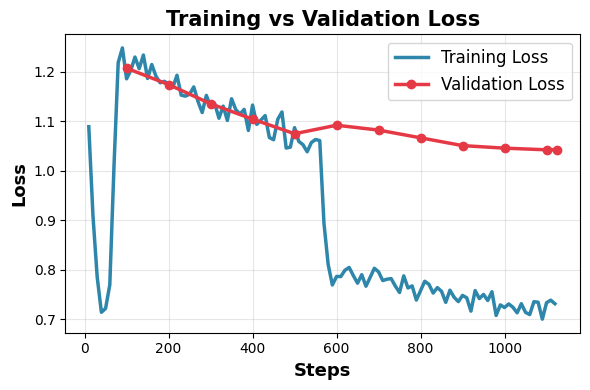

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# Get log history
logs = trainer.state.log_history

# Let's inspect a few to know the keys
if not logs:
    print("No logs found. Did training complete?")
else:
    print("Found logs. Example entries:")
    print(logs[:3])  # Preview first few entries

    # Extract training and evaluation logs safely
    train_logs = [log for log in logs if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in logs if 'eval_loss' in log]

    # Convert to DataFrames for easier plotting
    train_df = pd.DataFrame(train_logs)
    eval_df = pd.DataFrame(eval_logs)

    # If 'step' is missing, create a simple index
    train_x = train_df['step'] if 'step' in train_df.columns else range(len(train_df))
    eval_x = eval_df['step'] if 'step' in eval_df.columns else range(len(eval_df))

    plt.figure(figsize=(6, 4))

    # Training Loss
    plt.plot(train_x, train_df['loss'],
             label='Training Loss', color='#2E86AB', linewidth=2.5)

    # Validation Loss
    if 'eval_loss' in eval_df.columns:
        plt.plot(eval_x, eval_df['eval_loss'],
                 label='Validation Loss', color='#E63946', linewidth=2.5, marker='o')

    plt.xlabel('Steps', fontsize=13, fontweight='bold')
    plt.ylabel('Loss', fontsize=13, fontweight='bold')
    plt.title('Training vs Validation Loss', fontsize=15, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Evaluation

In [78]:

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import numpy as np
from tqdm import tqdm
import evaluate
import nltk
nltk.download('punkt', quiet=True)

class PerplexityEvaluator:
    def __init__(self, model_path):
        print(f" Loading model from: {model_path}")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
        self.model = AutoModelForCausalLM.from_pretrained(
            model_path,
            trust_remote_code=True,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            device_map="cuda" if torch.cuda.is_available() else "cpu"
        )
        self.model.eval()

    def evaluate(self, test_samples, max_samples=10):
        print(f"\n Evaluating perplexity on {min(max_samples, len(test_samples))} samples...")
        total_loss = 0

        for sample in tqdm(test_samples[:max_samples], desc="Calculating Perplexity"):
            text = f"User: {sample['instruction']}\nAssistant: {sample['response']}"
            inputs = self.tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=512
            )
            inputs = {k: v.to(self.model.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs, labels=inputs["input_ids"])
                total_loss += outputs.loss.item()

        avg_loss = total_loss / min(max_samples, len(test_samples))
        perplexity = np.exp(avg_loss)

        print(f"\n{'='*60}")
        print("PERPLEXITY RESULT")
        print(f" Perplexity: {perplexity:.2f} ")
        print(f"{'='*60}\n")

        return perplexity





In [79]:

# RUN EVALUATION

MODEL_PATH = "/content/phi3-recipe-finetuned"

# Use your validation or sample test dataset
test_data = [
    {'instruction': main_data.iloc[i]['instruction'],
     'response': main_data.iloc[i]['response']}
    for i in range(min(100, len(main_data)))
]

evaluator = PerplexityEvaluator(MODEL_PATH)
perplexity_score = evaluator.evaluate(test_data)

print("Perplexity Evaluation Complete!")
print(f"Final Perplexity: {perplexity_score:.2f}")


 Loading model from: /content/phi3-recipe-finetuned


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


 Evaluating perplexity on 10 samples...


Calculating Perplexity: 100%|██████████| 10/10 [00:00<00:00, 18.55it/s]


PERPLEXITY RESULT
 Perplexity: 2.52 

Perplexity Evaluation Complete!
Final Perplexity: 2.52


In [67]:
%cd /content/Chat_bot

# Remove all traces of the large file from history
!git filter-branch --force --index-filter \
  "git rm --cached --ignore-unmatch gpt2-african-recipes-final/model.safetensors" \
  --prune-empty --tag-name-filter cat -- --all


/content/Chat_bot
	 rewrites.  Hit Ctrl-C before proceeding to abort, then use an
	 alternative filtering tool such as 'git filter-repo'
	 (https://github.com/newren/git-filter-repo/) instead.  See the
	 filter-branch manual page for more details; to squelch this warning,
	 set FILTER_BRANCH_SQUELCH_WARNING=1.
Proceeding with filter-branch...

Rewrite ef43d867e7890ff4d30773224e462f254fbd3e91 (13/13) (0 seconds passed, remaining 0 predicted)    


In [80]:
# Move your model folder into the cloned repo
!mv /content/phi3-recipe-finetuned /content/Chat_bot/


In [81]:
# Find files larger than 100 MB
!find /content/Chat_bot/phi3-recipe-finetuned -type f -size +100M


/content/Chat_bot/phi3-recipe-finetuned/model-00002-of-00004.safetensors
/content/Chat_bot/phi3-recipe-finetuned/model-00004-of-00004.safetensors
/content/Chat_bot/phi3-recipe-finetuned/model-00003-of-00004.safetensors
/content/Chat_bot/phi3-recipe-finetuned/model-00001-of-00004.safetensors


In [82]:
# Path to your repo
gitignore_path = "/content/Chat_bot/.gitignore"

# Add safetensors files to gitignore
with open(gitignore_path, "a") as f:
    f.write("\n# Ignore large model weights\n")
    f.write("phi3-recipe-finetuned/model-00001-of-00004.safetensors\n")
    f.write("phi3-recipe-finetuned/model-00002-of-00004.safetensors\n")
    f.write("phi3-recipe-finetuned/model-00003-of-00004.safetensors\n")
    f.write("phi3-recipe-finetuned/model-00004-of-00004.safetensors\n")



In [83]:
!git add -A
!git commit -m "Pushed Phi3-mini-instuct-Model"


[main 1328e5c] Pushed Phi3-mini-instuct-Model
 10 files changed, 93897 insertions(+)
 create mode 100644 phi3-recipe-finetuned/added_tokens.json
 create mode 100644 phi3-recipe-finetuned/config.json
 create mode 100644 phi3-recipe-finetuned/generation_config.json
 create mode 100644 phi3-recipe-finetuned/model.safetensors.index.json
 create mode 100644 phi3-recipe-finetuned/special_tokens_map.json
 create mode 100644 phi3-recipe-finetuned/tokenizer.json
 create mode 100644 phi3-recipe-finetuned/tokenizer.model
 create mode 100644 phi3-recipe-finetuned/tokenizer_config.json
 create mode 100644 phi3-recipe-finetuned/training_args.bin


In [84]:
!git push origin main --force


Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 12 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 700.63 KiB | 5.15 MiB/s, done.
Total 13 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com//AkotoChristine/Chat_bot.git
   ef43d86..1328e5c  main -> main
